In [1]:
!pip install tabulate
!pip install -q qiskit  qiskit[visualization] qiskit-aer qiskit-ibm-runtime
# Setup: Import everything we need
import math
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from tabulate import tabulate
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

print(f"✅ Qiskit version: {qiskit.__version__}")
print("🚀 Ready to go!")

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/jupyter-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/jsonpointer-3.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
zsh:1: no matches found: qiskit[visualization]
✅ Qiskit version: 2.1.2
🚀 Ready to go!


# Question 1 (Solved)

## Randomized Search

Suppose you are given an unstructured database of all the $2^4$ possible 4-bit binary strings, out of which $x$ (to be provided as input) is the string that you wish to search for in the database.

Consider $2^4$ states (each identified by a unique label in $\{0\}\cup[2^4-1]$). Our goal is to find the state which is labelled $x$. A possible strategy to do is that we begin at some state uniformly at random. If the state is not labelled $x$, then we transition to any of the $2^4$ states uniformly at random (including itself). Else, we have found our desired state, so we stay put, or in other words, transition to the same state.

These rules of state transition can be captured using a $2^4\times 2^4$ matrix $M$ (with row and column indices going from $0$ to $2^4-1$) encoding the state transition probabilities as follows - 
        \begin{align*}
            \\M_{ij}=\begin{cases}
                \frac{1}{2^4},\text{ if }i\neq x,\\
                1,\text{ if }i=x\text{ and }j=x \text{ (absorbing state)},\\
                0,\text{ otherwise},
            \end{cases}
        \end{align*}
        
where $M_{ij}$ denotes the probability of transitioning from the state labelled $i$ to the state labelled $j,\ \forall i,j\in\{0\}\cup[2^4-1]$.

Let a $2^4\times 1$ column vector $v^{(t)}$ (with row indices running from $0$ to $2^4-1$) denote the state of the (probabilistic) system at the end of the $t^{\text{th}}$ transition, where $t\in \mathbb{Z}^+\cup \{0\}$. That is to say, $v^{(t)}_i$ encodes the probability of reaching a state with the label $i$ by the end of the $t^{\text{th}}$ transition, $\forall i\in \{0\}\cup[2^4-1]$, $\forall t\in \mathbb{Z}^+\cup \{0\}$. Then, note that 
\begin{align*}
    v^{(t+1)}=M.v^{(t)}=M^{(t+1)}.v^{(0)},\ \forall t\in \mathbb{Z}^+\cup \{0\},
\end{align*}

where $v^{(0)}_i=\frac{1}{2^4},\ \forall i\in \{0\}\cup[2^4-1]$.

<ol style="list-style-type:lower-roman">
    <li>Simulate a randomized search for the string $x$ using the matrix $M$ and the vector $v^{(t)}$, and plot how the vector $v^{(t)}$ changes with respect to each of the $t^{\text{th}}$ transition, $t\in \{0,1,\ldots, 8\}$.</li>
    <li>Compare the element $v^{(t)}[x]$ with the theoretical probability $1-\big(1-\frac{1}{2^4}\big)^t$ of reaching the state with the label $x$ within $t$ transitions, for each value of $t\in \{0,1,\ldots, 8\}$.</li>
</ol>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_transition_matrix(N, marked_element):
    """Create NxN transition matrix for sampling with marked absorbing state"""
    P = np.zeros((N, N))

    for col in range(N):
        element = col
        if element == marked_element:
            # Marked element: absorbing state - once there, stay there
            P[marked_element, col] = 1.0
        else:
            # Other elements: uniform transition to all states (including marked)
            P[:, col] = 1/N

    return P

def simulate_probability_evolution(N, marked_element, steps=5):
    """Simulate how probabilities evolve over time"""

    # Initial uniform distribution
    prob_vector = np.ones(N) / N

    # Transition matrix
    P = create_transition_matrix(N, marked_element)

    print(f"Transition Matrix (N={N}, marked={marked_element}):")
    print(tabulate(P, tablefmt="fancy_grid", floatfmt=".4f"))
    print()

    # Track evolution
    evolution = [prob_vector.copy()]

    for step in range(1, steps+1):
        prob_vector = P @ prob_vector
        evolution.append(prob_vector.copy())

    return evolution, P

def plot_evolution(evolution, marked_element, N):
    """Plot histograms showing probability distribution at each step"""

    # Create subplots for different steps
    fig, axes = plt.subplots(3, 3, figsize=(17, 12))
    axes = axes.flatten()

    steps_to_show = [i for i in range(len(evolution))]
    elements = list(range(0, N))

    for i, step in enumerate(steps_to_show):
        if step < len(evolution):
            probs = evolution[step]

            # Color marked element differently
            colors = ['red' if elem == marked_element else 'blue' for elem in elements]

            axes[i].bar(elements, probs, color=colors, alpha=0.7)
            axes[i].set_title(f'Step {step}')
            axes[i].set_xlabel('Element')
            axes[i].set_ylabel('Probability')
            axes[i].set_ylim(0, 1)
            axes[i].grid(True, alpha=0.3)

            # Highlight marked element probability
            marked_prob = probs[marked_element]
            axes[i].text(marked_element, marked_prob + 0.05, f'{marked_prob:.3f}',
                        ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_theoretical_comparison(evolution, marked_element, N):
    """Compare simulation results with theoretical formula 1-(15/16)^t"""

    # Extract probabilities of marked element at specific steps
    simulation_steps = [i for i in range(1,9)]
    simulation_probs = []

    for step in simulation_steps:
        if step < len(evolution):
            marked_prob = evolution[step-1][marked_element]
            simulation_probs.append(marked_prob)

    # Calculate theoretical probabilities using 1-(15/16)^t
    # For N=16, probability of not being absorbed at each step is 15/16
    # So probability of being in marked state at step t is 1-(15/16)^t
    theoretical_steps = list(range(1, 9))  # t = 1,2,...,16
    prob_not_absorbed = (N-1)/N  # This is 15/16 for N=16

    # Probability of being in marked state at step t: 1-(15/16)^t
    theoretical_probs = [1 - (prob_not_absorbed)**t for t in theoretical_steps]

    # Create comparison plot
    plt.figure(figsize=(10, 8))

    # Main plot: Compare simulation with 1-(15/16)^t
    plt.bar(simulation_steps, simulation_probs, alpha=0.7, color='red',
            label='Simulation P(marked)', width=0.4)
    plt.plot(theoretical_steps, theoretical_probs, 'b--', label='Theoretical: 1-(15/16)^t',
             linewidth=3, alpha=0.8)

    # Add points for the specific steps we're comparing
    theory_at_sim_steps = [1 - (prob_not_absorbed)**t for t in simulation_steps]
    plt.plot(simulation_steps, theory_at_sim_steps, 'bs', markersize=8,
             label='Theory at simulation steps')

    plt.xlabel('Step (t)', fontsize=12)
    plt.ylabel('Probability of being in marked state', fontsize=12)
    plt.title('Simulation vs Theory: P(marked state) = 1-(15/16)^t', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Add text annotations showing the close match
    for i, (step, sim_prob, theo_prob) in enumerate(zip(simulation_steps, simulation_probs, theory_at_sim_steps)):
        diff = abs(sim_prob - theo_prob)
        plt.annotate(f'Δ={diff:.6f}',
                    xy=(step, sim_prob), xytext=(step+0.2, sim_prob+0.02),
                    fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print numerical comparison
    print("\nNumerical Comparison:")
    print("Step\tSimulation P(marked)\tTheory 1-(15/16)^t\tDifference")
    print("-" * 65)
    for step, sim_prob in zip(simulation_steps, simulation_probs):
        theo_prob = 1 - (prob_not_absorbed)**step
        diff = abs(sim_prob - theo_prob)
        print(f"{step}\t{sim_prob:.8f}\t\t{theo_prob:.8f}\t\t{diff:.2e}")

    print(f"\nNote: For N={N}, the theoretical formula is 1-({N-1}/{N})^t")

Transition Matrix (N=16, marked=15):
╒════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0000 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0000 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0625 │ 0.0000 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────

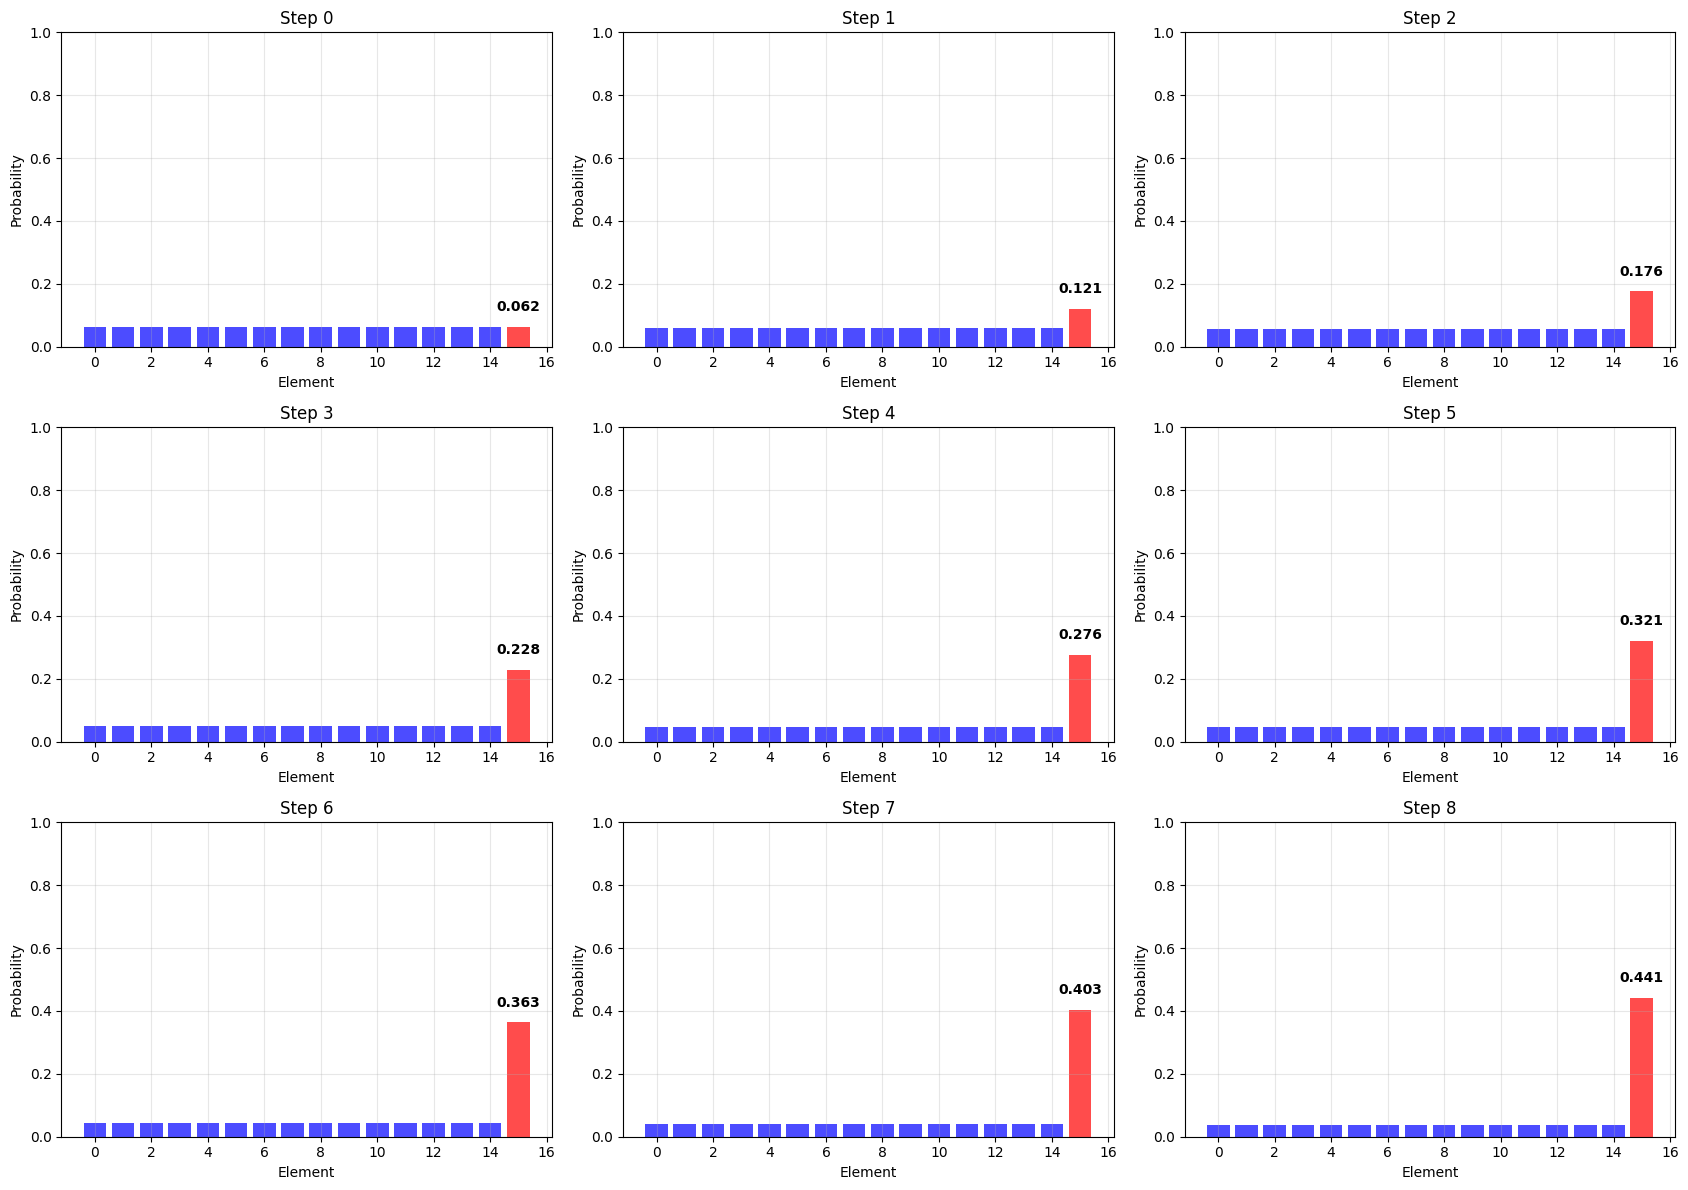

In [3]:
#Input x (the string to be searched)
x = int(input("Enter the input string x to be searched : "),2)

# Run simulation
N = 2**4
steps = 8

evolution, P = simulate_probability_evolution(N, x, steps)
plot_evolution(evolution, x, N)

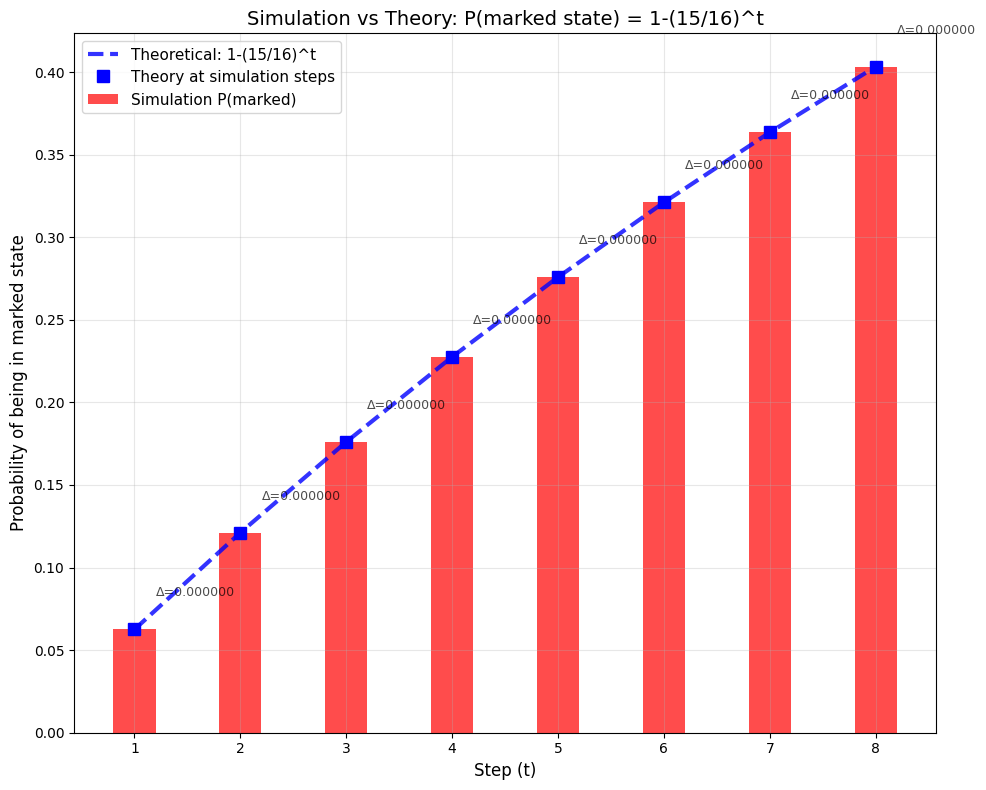


Numerical Comparison:
Step	Simulation P(marked)	Theory 1-(15/16)^t	Difference
-----------------------------------------------------------------
1	0.06250000		0.06250000		0.00e+00
2	0.12109375		0.12109375		0.00e+00
3	0.17602539		0.17602539		0.00e+00
4	0.22752380		0.22752380		0.00e+00
5	0.27580357		0.27580357		0.00e+00
6	0.32106584		0.32106584		0.00e+00
7	0.36349923		0.36349923		0.00e+00
8	0.40328053		0.40328053		0.00e+00

Note: For N=16, the theoretical formula is 1-(15/16)^t


In [4]:
plot_theoretical_comparison(evolution, x, N)

# Question 2

## Grover's Algorithm

### Background

Grover's algorithm is one of the most famous and ingenious quantum algorithms, that provides a **quadratic speedup** over any classical or randomized algorithm for searching an unsorted database. That is, while a classical computer needs to check roughly $\frac{N}{2}$ items on average to find what it's looking for, Grover's algorithm needs only about $\sqrt{N}$ steps.

---------------

### Step 0: Basic Circuit Components (Bonus Question - 0 marks)

Before we dive into building a circuit that implements Grover's Search, here is a bonus question for you. Can you prove that the two circuits below perform the same operation, in the sense that both of them implement the CCCX gate (which is a four-qubit generalisation of the Toffoli gate, which is defined in **the beginning of Question 3**)?

<center>
    <figure class="half" style=""display:flex>
        <img src="attachment:b0fbd03b-735c-48a3-a7bd-c16e62d4ff3f.png" width="200">
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
        <img src="attachment:d44c9a51-a05a-405b-97d8-da42cf390d82.png" width="340">
    </figure>
</center>

---------------

### Step 1: Building the Oracle

[Note - You are allowed to use the multi-controlled phase gate to build circuits using qiskit's built-in $\texttt{mcp()}$ method.]

Consider the equal superposition state $|\psi\rangle$ of all the 4-qubit computational basis states (i.e., $|0000\rangle,\ |0001\rangle,\ \ldots,\ |1111\rangle$). Construct a python function that return as output a quantum **oracle** operator (circuit) $O$ that "marks" the target state (i.e., the state $|x\rangle$, where $x$ is provided as input) by flipping its phase from +1 to -1. <b>Visualise the circuit</b>, and show that it correctly marks the target state.

[As per the diagram given below, this operation is equivalent to that of reflecting about the axis $|\alpha\rangle$, where 
\begin{align*} 
    &|\alpha\rangle=\dfrac{1}{\sqrt{2^4-1}}\sum\limits_{y\in \{\{0\}\cup[2^4-1]\}\backslash \{x\}} |y\rangle,\text{ and} \\
    &|\beta\rangle=|x\rangle,
\end{align*}
for the current setting of our problem.]
<center>
    <div>
        <img src="attachment:f5539b91-df8b-4f3f-a1a3-1fa7dac9a957.png" width="300">
    </div>
</center>

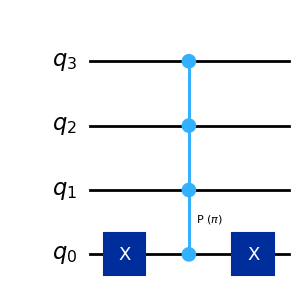

In [32]:
from qiskit.circuit.library import PhaseGate
from qiskit.quantum_info import Statevector

def oracle_4qubit(target: str) -> QuantumCircuit:
    """
    Oracle O_x on 4 qubits that flips the phase of |x> and leaves other basis states unchanged.
    Qubit order: target[0] -> q0, ..., target[3] -> q3.
    """
    assert len(target) == 4 and set(target) <= {'0','1'}, "target must be a 4-bit string"
    qc = QuantumCircuit(4, name=f"O({target})")

    # Mask 0-bits so that |x> is mapped to |1111>
    for q, b in enumerate(target):
        if b == '0':
            qc.x(q)

    # Multi-controlled-Z as a 3-controlled Phase(pi) with q0,q1,q2 controls and q3 as the phase target
    qc.append(PhaseGate(np.pi).control(3), [0, 1, 2, 3])

    # Unmask
    for q, b in enumerate(target):
        if b == '0':
            qc.x(q)

    return qc

# Make Sures that Marked strings phase changes by pi if oracle is applied
test_string = '1110'

oracle = oracle_4qubit(test_string)
oracle = oracle.reverse_bits()
oracle.draw('mpl', reverse_bits=True)


### Step 2: Building the Grover Operator

The **Grover operator** combines the oracle with a "diffusion operator" $D$ that amplifies marked states (as per the above diagram, this operation is equivalent to that of reflecting $O|\psi\rangle$ about the state $|\psi\rangle$ to obtain the state $G|\psi\rangle=DO|\psi\rangle$). Construct a python function that return as output the circuit for this Grover operator $G=DO$, using only the basic gates supported by qiskit, and **visualize the circuit**.

[Hint : Remember the CCCX gate from the bonus question.]

In [33]:

# ---------- Diffusion operator D for 4 qubits ----------
def diffusion_4q() -> QuantumCircuit:
    """4-qubit Grover diffusion operator using only basic gates (MCX will decompose)."""
    qc = QuantumCircuit(4, name="D")
    # H^⊗4, X^⊗4
    qc.h(range(4))
    qc.x(range(4))
    # MCZ on all four: H on last, CCCX, H on last
    qc.h(3)
    qc.mcx([0, 1, 2], 3)    
    qc.h(3)
    # X^⊗4, H^⊗4
    qc.x(range(4))
    qc.h(range(4))
    return qc

# ---------- Grover operator G = D ∘ O ----------
def grover_operator_4q(target):
    G = QuantumCircuit(4)
    G.compose(oracle_4qubit(target), inplace=True)
    G.compose(diffusion_4q(), inplace=True)
    return G


def grover_search_circuit(target: str, k: int) -> QuantumCircuit:
    qc = QuantumCircuit(4, 4, name=f"Grover({target})")
    qc.h(range(4))                       # prepare |ψ>
    G = grover_operator_4q(target)
    for _ in range(k):
        qc.compose(G, inplace=True)
    qc.measure(range(4), range(4))
    return qc



### Step 3: The Complete Circuit

<ol style="list-style-type:lower-alpha">
    <li>Calculate the optimal number of Grover iteration $k$ required to acheive the maximum success probability of getting the result $x$ upon measuring the final state $G^k|\psi\rangle=(DO)^k|\psi\rangle$.</li>
    <li>Taking as input $x$ the string to search for (in the database of all possible $2^4$ 4-bit binary strings), put all the above components together to build a quantum circuit performing Grover's search for $x$ on the database, and <b>visualize the circuit</b>.</li>
    <li>Take $10,000$ measurements of the final state obtained from the above circuit, and plot a histogram of the frequencies of all the observed states.</li>
    <li>As you saw how the probabilities of the state of the (probabilistic) system were plotted for each successive round $t$ in Question 1, similarly plot how the amplitudes of the quantum state changes with each successive application of the grover operator, or in other words, with the $t^{\text{th}}$ grover iteration, $t\in\{0,1,\ldots,8\}$.</li>
    <li>Compare the results obtained with that obtained from the randomized search in Question 1.</li>
</ol>

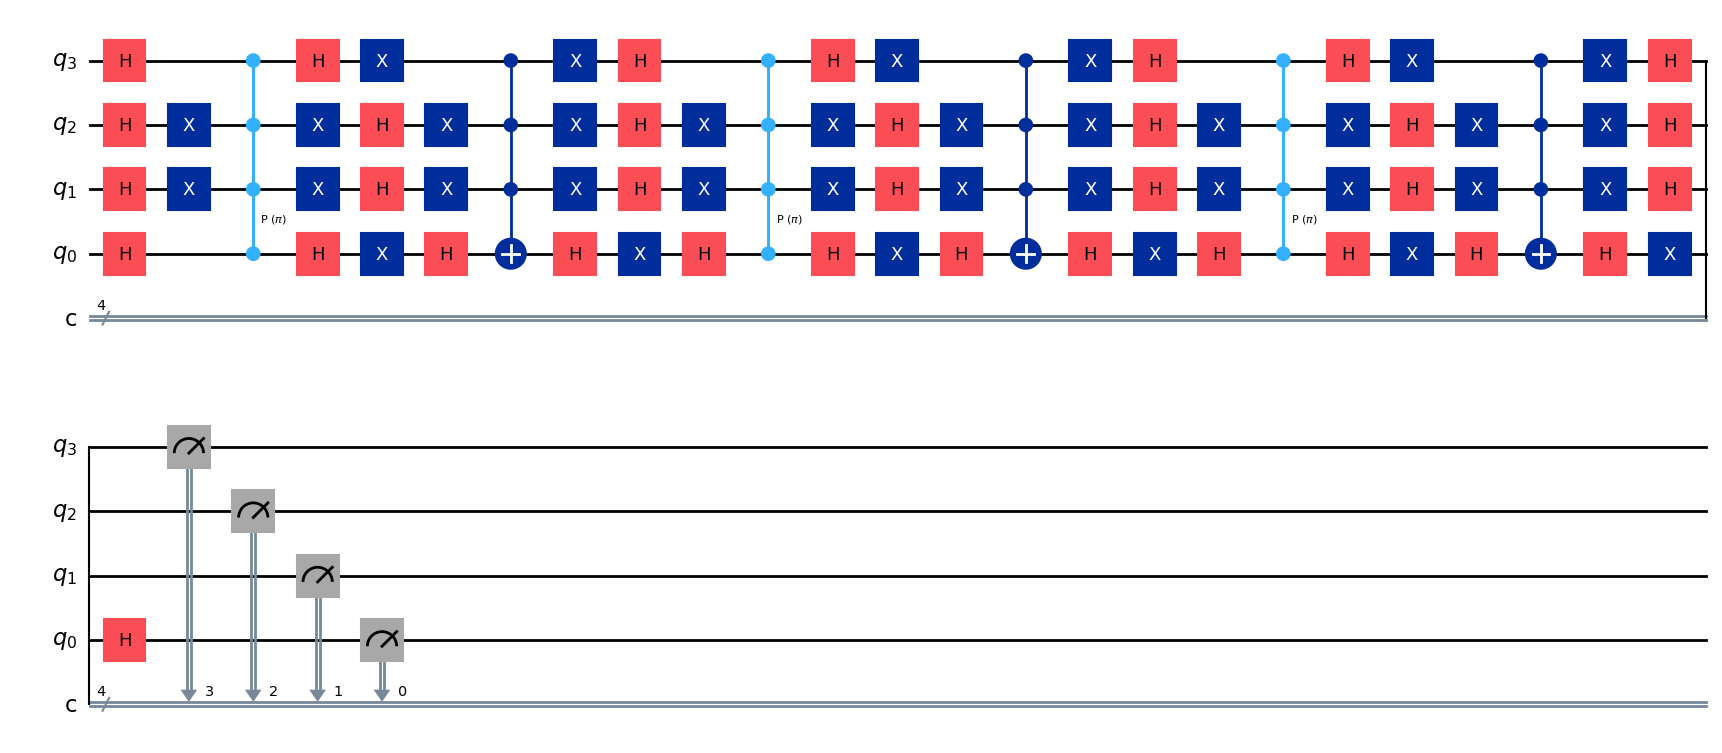

In [ ]:
x = "1001" # Marked string
k = 3 # optimal number of iterations
circ = grover_search_circuit(x, k)
circ = circ.reverse_bits()
(circ.draw('mpl', reverse_bits=True))

In [45]:
from qiskit import transpile
try:
    from qiskit_aer import AerSimulator
    sim = AerSimulator()
    job = sim.run(transpile(circ, sim, optimization_level=2), shots=10_000)
    counts = job.result().get_counts()
except Exception:
    # fallback if Aer isn't available
    from qiskit import BasicAer
    backend = BasicAer.get_backend("qasm_simulator")
    counts = backend.run(transpile(circ, backend), shots=10_000).result().get_counts()
    

print(counts)  


{'1110': 23, '0010': 17, '0101': 23, '0111': 26, '1010': 29, '1011': 24, '1000': 26, '1001': 29, '1101': 9628, '1111': 28, '0001': 20, '0011': 23, '0000': 31, '1100': 25, '0100': 20, '0110': 28}


Text(0.5, 1.0, 'Frequency plot for measurements')

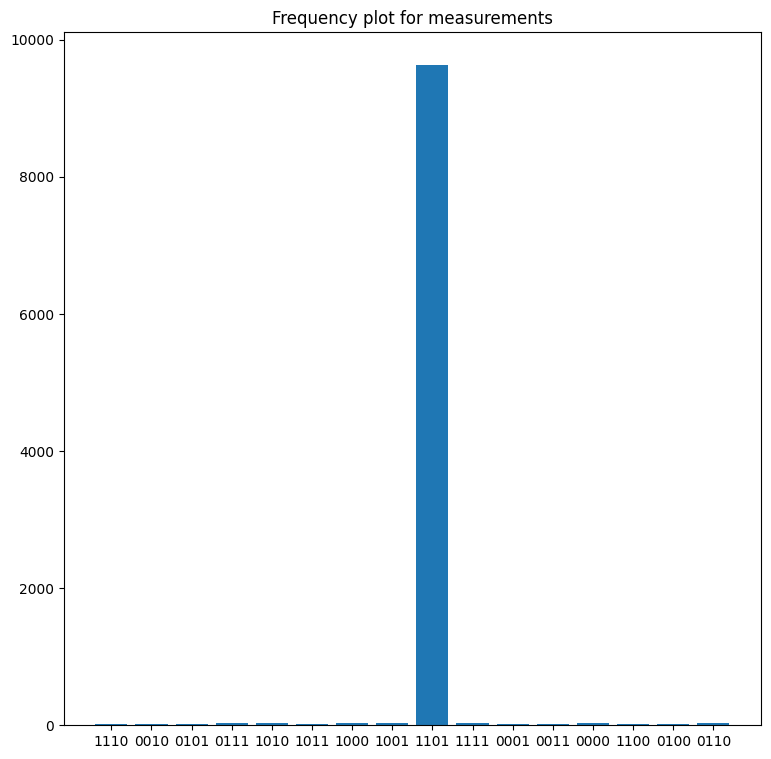

In [46]:
plt.figure(figsize=(9, 9))
plt.bar(counts.keys(), counts.values())
plt.title("Frequency plot for measurements")

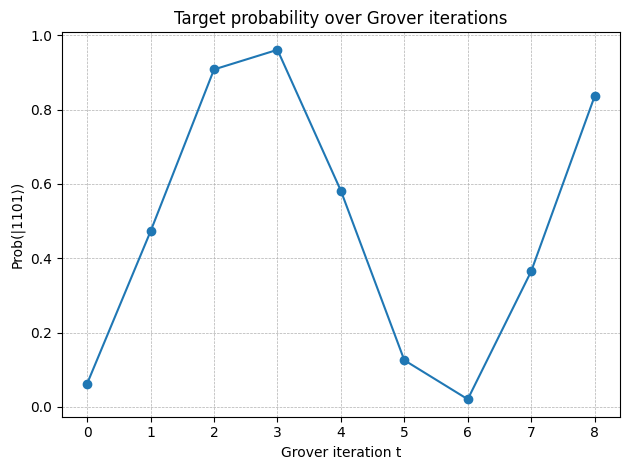

In [47]:

from qiskit.quantum_info import Statevector

def little_endian_index(bitstring: str) -> int:
    
    # return int(bitstring, 2)
    return int(bitstring[::-1], 2)

G = grover_operator_4q(x)
prep = QuantumCircuit(4); prep.h(range(4))
psi = Statevector.from_instruction(prep)

idx = little_endian_index(x)

probs = [abs(psi.data[idx])**2] # t=0

for _t in range(8):
    psi = psi.evolve(G)
    probs.append(abs(psi.data[idx])**2)



# Plot target probability over t=0..3
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(9), probs, marker='o')
plt.xlabel("Grover iteration t"); plt.ylabel(f"Prob(|{x}⟩)")
plt.title("Target probability over Grover iterations")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout(); plt.show()



# Question 3

## Application of Inverse Quantum Fourier Transform

[**NOTE** - The Toffoli gate can be used to build circuits using qiskit's built-in $\texttt{ccx()}$ method.]

Consider the **Toffoli gate**, also known as the **CCNOT gate**, or the **CCX gate**, that is defined as follows-
        \begin{align*} 
            \mathrm{CCNOT}\ |a,b,c\rangle = \mathrm{CCNOT}\ |a,b,c\oplus (a\wedge b)\rangle,\ \ \ \forall a,b,c\in\{0,1\},
        \end{align*}
where $\oplus$ denotes the binary $\mathsf{XOR}$ operation, and $\mathsf{\wedge}$ denotes the binary AND operation. 

In other words, the Toffoli gate applies the $\mathrm{X}$ gate on the third qubit if and only if the first two qubits are $|1\rangle$.

a.&nbsp; Represent the above gate as a unitary matrix $U$, and compute the eigenvector $| u\rangle$ corresponding to the spectral radius $r=e^{2\pi i\phi}$ of $U$ (i.e., the maximum eigenvalue of $U$), for some $\phi\in[0,2\pi)$. 

In [13]:
import numpy as np
import math

U = []

for a in range(2):
    for b in range(2):
        for c in range(2):
            if a and b:
                U.append(4 * a + 2 * b + c ^ 1)
            else:
                U.append(4 * a + 2 * b + c)
        
U = np.eye(8)[U].astype(int).T
print("Matrix: ", U)


Matrix:  [[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


b.&nbsp; Consider the following two registers - 
<ol style="list-style-type:lower-roman">
    <li>the first register contains 3 qubits initially in the state $|0\rangle$, and</li>
    <li>the second register is initialised to the above eigenvector $|u\rangle$.</li>
</ol>    
Using the above two registers (and auxilliary qubits as required), create a quantum circuit, using only the basic gates supported by qiskit, that estimate the phase $\phi$ of the spectral radius $r$ of $U$, and <b>visualise the circuit</b>. Measure $20$ times the final outcome on the first register, and report the $\phi$ values observed.

In [20]:
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def iqft_in_place(qc: QuantumCircuit, anc):
    """
    In-place inverse QFT on 'anc' (anc[0] is MSB, anc[-1] is LSB).
    Uses only H, CP, and SWAP.
    """
    n = len(anc)
    # Bit-reversal (to make MSB..LSB order in classical readout)
    for i in range(n // 2):
        qc.swap(anc[i], anc[n - 1 - i])
    # Inverse QFT core
    for k in range(n - 1, -1, -1):     # k = n-1 .. 0
        qc.h(anc[k])
        for m in range(k):
            qc.cp(-pi / (2 ** (k - m)), anc[m], anc[k])

def generate_circuit(N: int) -> QuantumCircuit:
   
    if N < 1:
        raise ValueError("N must be >= 1")

    # --- Registers ---
    anc = QuantumRegister(N, "anc")   # first register: |0...0>
    sys = QuantumRegister(3, "sys")   # system for Toffoli (controls: s0,s1; target: s2)
    creg = ClassicalRegister(N, "c")
    qc = QuantumCircuit(anc, sys, creg, name=f"QPE_Toffoli_phi_{N}")

    # --- Prepare |u_-> = (|110> - |111>)/√2 on system ---
    # Make |110>
    qc.x(sys[0])
    qc.x(sys[1])
    # Put target into |-> = (|0> - |1>)/√2  (H then Z)
    qc.h(sys[2])
    qc.z(sys[2])

    # --- Hadamards on ancillas ---
    qc.h(anc)

    # --- Controlled-U^{2^k} ---
    # Toffoli has order 2 → only U^{1} (i.e., k corresponding to LSB) matters.
    # We treat anc[0] as MSB, anc[N-1] as LSB (post-IQFT the readout is MSB..LSB).
    # Implement a 3-controlled X with controls [anc[LSB], sys[0], sys[1]] onto sys[2].
    qc.mcx([anc[N - 1], sys[0], sys[1]], sys[2])

    # --- Inverse QFT on ancillas ---
    iqft_in_place(qc, anc)

    # --- Measure ancillas ---
    qc.measure(anc, creg)

    return qc


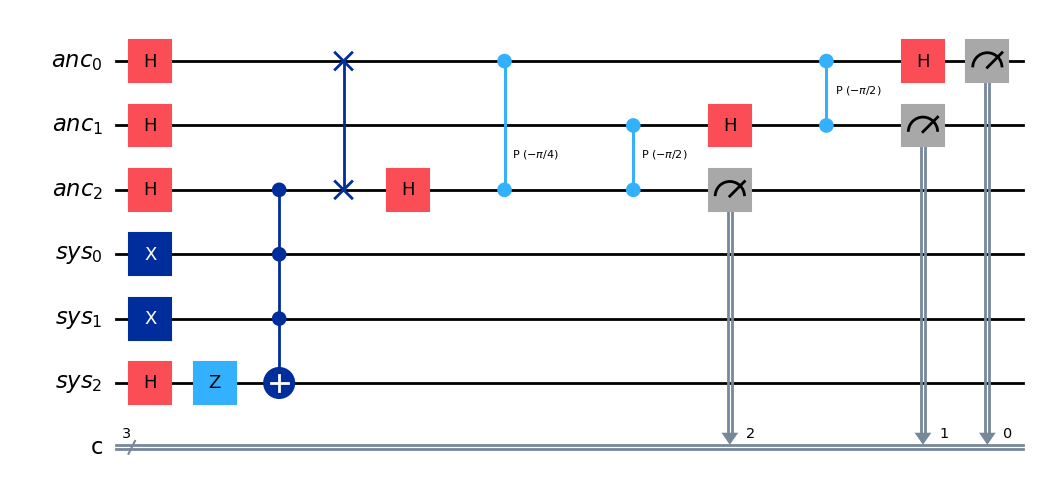

In [21]:
qc = generate_circuit(3)
qc.draw('mpl')

In [22]:
'''
Eigen vector = (|110> - |111>) / sqrt(2)
corresponding eigen value = -1 = exp(2*pi*(0.5))
phi = 0.5
'''


# Run 20 shots:
try:
    from qiskit_aer import AerSimulator
    sim = AerSimulator()
    result = sim.run(transpile(qc, sim, optimization_level=1), shots=20).result()
    counts = result.get_counts()
except Exception:
    from qiskit import BasicAer
    backend = BasicAer.get_backend("qasm_simulator")
    counts = backend.run(transpile(qc, backend, optimization_level=1), shots=20).result().get_counts()

counts = {k[::-1]: v for k, v in counts.items()}

print("Counts:", counts)

# Convert measured bits (MSB..LSB) -> phi in [0,1)
def phi_from_bits(bits):
    return int(bits, 2) / 8

phi_observed = []
for b, f in counts.items():
    phi_observed += [phi_from_bits(b)] * f
print("phi values:", phi_observed)



Counts: {'100': 20}
phi values: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


c.&nbsp; Repeat the exercise in part (b), but now with the first register containing 5 qubits, all initialized to the state $|0\rangle$, and <b>visualize the circuit</b>. Compare the results obtained from part (b) with that obatined in part (c).

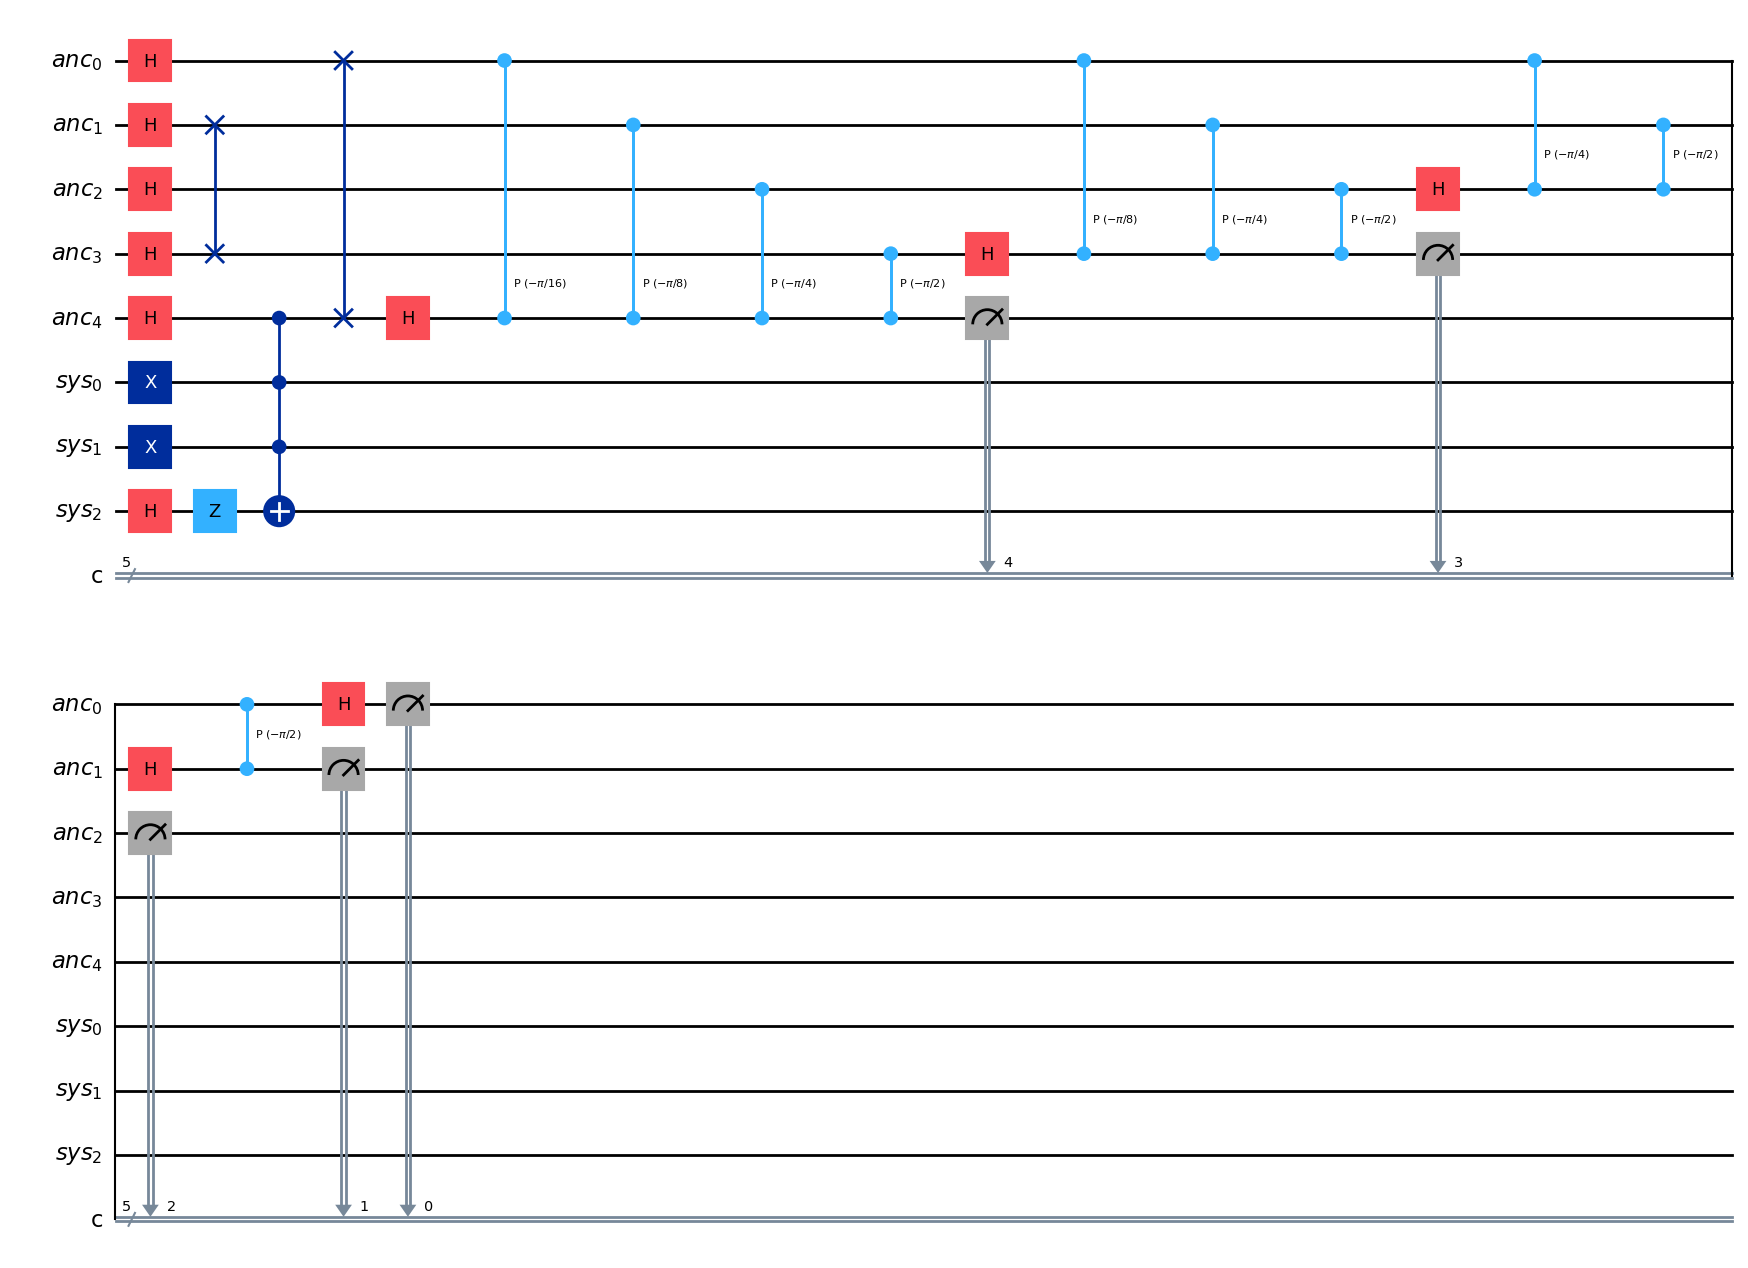

In [23]:
qc = generate_circuit(5)
qc.draw('mpl')

In [24]:

# Run 20 shots:
try:
    from qiskit_aer import AerSimulator
    sim = AerSimulator()
    result = sim.run(transpile(qc, sim, optimization_level=1), shots=20).result()
    counts = result.get_counts()
except Exception:
    from qiskit import BasicAer
    backend = BasicAer.get_backend("qasm_simulator")
    counts = backend.run(transpile(qc, backend, optimization_level=1), shots=20).result().get_counts()

counts = {k[::-1]: v for k, v in counts.items()}

print("Counts:", counts)

# Convert measured bits (MSB..LSB) -> phi in [0,1)
def phi_from_bits(bits):
    return int(bits, 2) / 32

phi_observed = []
for b, f in counts.items():
    phi_observed += [phi_from_bits(b)] * f
print("phi values:", phi_observed)



Counts: {'10000': 20}
phi values: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
